In [ ]:
'''
num_tokens_in_dataset = 3.3 billion
tokens_per_batch      = 256 × 512 = 128,000
tokens_per_epoch      = 3.3B
tokens_per_step       = 128,000
total_steps           = 1,000,000

total_tokens_seen = 1,000,000 × 128,000 = 128,000,000,000 (128 billion tokens seen)

epochs = total_tokens_seen / corpus_tokens
       ≈ 128B / 3.3B ≈ 38.78 ≈ 40 epochs

1 step = 1 batch
| Concept        | Means                                                   |
| -------------- | ------------------------------------------------------- |
| **1 step**     | 1 batch processed (forward + backward + optimizer step) |
| **1 batch**    | N sequences of length L (e.g., 256 × 512 = 128k tokens) |
| **1 epoch**    | Total tokens seen = size of dataset                     |
| **1000 steps** | You’ve processed 1000 batches (not 1000 tokens)         |

'''



---



In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
CHECKPOINT_DIR = '/content/drive/MyDrive/bert_checkpoints/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Hyper parameter suggestions to scale down the model. and fit a humble hardware usage.

| Hyper-parameter         | Value                                                    | Rationale                                                                                                                              |
| ----------------------- | -------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Model depth**         | `num_layers = 6`                                         | Half of BERT-base (12 → 6) cuts compute by 50 % but still shows transformer behaviour.                                                 |
| **Hidden size**         | `hidden_size = 512`                                      | Keeps memory low; 8 heads × 64 d each.                                                                                                 |
| **Intermediate (FFN)**  | `intermediate_size = 4×hidden = 2048`                    | Same width multiplier as BERT.                                                                                                         |
| **Heads**               | `num_heads = 8`                                          | `512 / 8 = 64` head dim.                                                                                                               |
| **Max sequence length** | `max_len = 128`                                          | Shorter sequences dominate BookCorpus; 128 gives 2× faster attention than 512.                                                         |
| **Batch size (GPU)**    | `global_batch_tokens ≈ 16 384`                           | On T4 you fit **`batch_size = 128` sentences × 128 tokens** in fp16.  If OOM, drop to 96.                                              |
| **Grad-accum steps**    | `accum_steps = 2`                                        | Effective batch 256 seq without memory blow-up (tokens/step = 32 768).                                                                 |
| **Dataset slice**       | **45 M tokens ≈ 350 k sentences**<br>`dataset[:350_000]` | 350 k × 128 ≈ 45 M tokens.  Copy from BookCorpus subset.                                                                               |
| **Training steps**      | `steps = 35 000`                                         | 35 k × 32 768 tokens/step ≈ 1.15 G *token-updates* but with accum=2 you physically run 17 500 optimizer steps.  Runtime \~3.5 h on T4. |
| **Epochs**              | `epochs = ceil(steps × batch / dataset_size) ≈ 13`       | Doesn’t matter; just iterate `steps` times.                                                                                            |
| **Learning rate**       | `lr = 5e-4`                                              | Shallower models need slightly higher LR.                                                                                              |
| **Warm-up**             | `warmup_steps = 5 % of total = 1750`                     | Linear warm-up then cosine decay.                                                                                                      |
| **Weight decay**        | `0.01`                                                   | Same as paper.                                                                                                                         |
| **Dropout**             | `0.1`                                                    |                                                                                                                                        |
| **Masking prob**        | `0.15` (unchanged)                                       |                                                                                                                                        |
| **Optimizer**           | `AdamW (β1=0.9, β2=0.98, ε=1e-6)`                        | Slightly bigger β2 stabilises with fp16.                                                                                               |
| **Precision**           | **Mixed precision (fp16/bfloat16)**                      | `torch.cuda.amp.autocast()` + `GradScaler`.  Halves memory & boosts speed.                                                             |
| **Gradient clip**       | `1.0`                                                    | Prevent rare fp16 explosions.                                                                                                          |
| **Scheduler**           | `CosineDecay` after warm-up                              | Smoother than linear for short runs.                                                                                                   |
| **Checkpoint every**    | 5 000 steps                                              | ≈ 30 min on T4.                                                                                                                        |


In [ ]:
!pip install datasets transformers

import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
import random
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import AutoTokenizer


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True) # this is the huggingface tokenizer.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
dataset = load_dataset("rojagtap/bookcorpus", split="train[:1%]")  #only subset,
lines = dataset["text"]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True) # this is the huggingface tokenizer.
#The use_fast argument in Hugging Face's transformers library, specifically
#when loading a tokenizer with AutoTokenizer.from_pretrained(), controls whether
#to load the "fast" (Rust-backed) version of the tokenizer or the "slow" (Python-backed) version.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

books_large_p1.txt:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

books_large_p2.txt:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/74004228 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
lines = ["Aayush loves AI",
         "He loves poker",
         "He likes piiza"]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True) # this is the huggingface tokenizer.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def create_data(lines, tokenizer, max_seq_length = 128, mlm_prob = 0.15):
  examples = []
  for i in range(len(lines) - 1):

    sentence_a = lines[i]

    if random.random() < 0.5:
      sentence_b = lines[i+1]
      isNext = 1
    else:
      sentence_b = random.choice(lines)
      isNext = 0

    encoding = tokenizer(
        sentence_a,
        sentence_b,
        padding = "max_length",
        truncation = True,
        max_length = max_seq_length,
        return_tensors = "pt",
        return_token_type_ids=True,
        return_attention_mask=True
    )
    #we gona get something like:
    # [CLS] sent_a_tokens [SEP] sent_b_tokens [SEP]
    # each tensor = 1, 128 = 1 x seq_len
    input_ids = encoding["input_ids"].squeeze() # [seq_len]
    token_type_ids = encoding["token_type_ids"].squeeze()
    attention_mask = encoding["attention_mask"].squeeze()

    # MLM masking
    labels = input_ids.clone() # [seq len] same shape as input_ids

    probability_matrix = torch.full(labels.shape, mlm_prob)  #Tensor filled with 0.15
    ## Create a 2x3 tensor filled with the value 5
    #a = torch.full([2, 3], 5)

    special_tokens_mask = tokenizer.get_special_tokens_mask(labels.tolist(), already_has_special_tokens=True)
    # this give a list of [seq_len] elements: 1 for [CLS], [SEP], [PAD], else 0

    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    # we make sure only non-special tokens have 0.15 chance of being masked.

    masked_indices = torch.bernoulli(probability_matrix).bool()
    #How it works:
    #The function iterates through the input tensor, element by element.
    #For each element, it compares the corresponding probability [OR THE NUMBER AT THAT INDEX]
    #with a random number between 0 and 1.
    #If the random number is less than or equal to the probability, the output element is set to 1; otherwise, it's set to 0.

    labels[~masked_indices] = -100
    #labels[~masked_indices] = -100  # -100 is ignored in CrossEntropyLoss

    # Replace 80% with [MASK]
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    input_ids[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # Replace 10% with random tokens
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.1)).bool() & masked_indices & ~indices_replaced
    random_tokens = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    input_ids[indices_random] = random_tokens[indices_random]

    examples.append({
        "input_ids": input_ids, #bert token ids, with [mask]
        "token_type_ids": token_type_ids, # 0 for a and 1 for b
        "attention_mask": attention_mask, # 1 for real token, 0 for padding
        "mlm_labels": labels, #same shape as input_ids, but -100 wherever token shouldn’t be predicted
        "nsp_label": torch.tensor(isNext) #1 if sentence B is next to A, 0 otherwise
    })

  return examples



TODO:
create_data materialises all tensors for 50 k sentences in RAM before you ever iterate. For bigger corpora switch to:

Return tokenised encodings immediately and compute masking on-the-fly in __getitem__.

Or use HF’s datasets map-style transform (dataset.map(masking_fn, batched=True)).
Saves memory and lets you stream ≥ BookCorpus size.

In [ ]:
print(len(lines))

3


In [ ]:
examples = create_data(lines, tokenizer)
print(len(examples))
'''print(examples[1]["nsp_label"])
decoded_text = tokenizer.decode(examples[1]["input_ids"])
decoded_text'''

2


'print(examples[1]["nsp_label"])\ndecoded_text = tokenizer.decode(examples[1]["input_ids"])\ndecoded_text'

In [ ]:
class BERTPretrainingDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        item = self.examples[idx]
        return {
            "input_ids": item["input_ids"],
            "token_type_ids": item["token_type_ids"],
            "attention_mask": item["attention_mask"],
            "mlm_labels": item["mlm_labels"],
            "nsp_label": item["nsp_label"],
        }


In [ ]:
dataset = BERTPretrainingDataset(examples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #batch size to be fixed

In [ ]:
class BERTEmbedding(nn.Module):
  def __init__(self, vocab_size, hidden_size, dropout = 0.1,
               max_position_embeddings = 512, type_vocab_size = 2 ):
    #“type vocab” is the vocabulary of segment types. there are only 2. sentence 0 and sentence 1
    super().__init__()
    # this is a constructor. when we create this class, basically we are creating a 30000 x 768 table and
    self.token_embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = hidden_size)

    self.position_embed = nn.Embedding(max_position_embeddings, hidden_size)

    self.segment_embed = nn.Embedding(type_vocab_size,hidden_size)

    self.dropout = nn.Dropout(dropout)
    self.layernorm = nn.LayerNorm(hidden_size) # = 768
    # normalizes the inputs to a layer across the feature dimensions for each individual sample in a batch

  def forward(self, input_ids, token_type_ids):
    batch_size, sequence_length = input_ids.shape # B x L

    #i need to get 1 embedding vector of size 768 = hidden size per token for all tokens in every batch shape = B x L x H
    token_embedding = self.token_embed(input_ids)

    position_ids = torch.arange(sequence_length, device = input_ids.device).unsqueeze(0).expand(batch_size, sequence_length)
    #above is b x l x seq_len or number of batches x sentences per batch x 512 tokens per sequence
    position_embedding = self.position_embed(position_ids)

    segment_embedding = self.segment_embed(token_type_ids)

    embedding = token_embedding + position_embedding + segment_embedding

    embedding = self.layernorm(embedding)
    embedding = self.dropout(embedding)

    return embedding


At the end of embedding layer for 1 Batch ONLY

Batch_Size x Seq_len X hidden_size

[256 x 512 x 768]

so 1 batch has 256 sentences

each sentence has 512 tokens

each token has 768 dimensional embeddings [token + pos + seg]

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, num_heads, hidden_size, dropout=0.1):
    super().__init__()
    #we will split the hidden size EQUALLY among different heads to learn different aspects of context.
    assert hidden_size % num_heads == 0

    self.num_heads = num_heads

    self.hidden_size = hidden_size #768

    self.dropout = nn.Dropout(dropout)

    self.query = nn.Linear(hidden_size, hidden_size)
    self.key   = nn.Linear(hidden_size, hidden_size)
    self.value = nn.Linear(hidden_size, hidden_size)

    self.out_proj = nn.Linear(hidden_size, hidden_size)

    self.head_dim = hidden_size // num_heads
    self.scale = math.sqrt(self.head_dim)

  def forward(self, x, mask = None):
    #input is 1 batch. so x.shape = bath_Size x seq_len x hidden_dim
    B, L, H = x.shape
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    #lets say we have heads [Heads]. Currently for our batch we have B x L x H
    # so now we need For every sequence in batch, split the hidden dim accross
    # [heads] equally. so b x l x h -> b x [heads] x l x head_dim such that
    # [heads] x head_dim = hidden_dim
    # so current we have B x L x H. First .view(B,L,[HEADS],[HEAD_DIM]) converts
    # this into B x L x Heads x Head_dim [dimensions are numbered from l t r]
    # then transpose(1,2) converts it to B x Heads x L x Head_dim. why? so that
    # attention can be applied accoss heads in parallel
    #so Q,k,v -> B x Heads x L x Head_dim

    Q = Q.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
    K = K.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
    V = V.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

    #what is k.transpose(-2,-1)
    #k = B x Heads x L x Head_dim
    #k.transpose(-2,-1) = B x Heads x Head_dim x L
    #so Q @ k.transpose(-2,-1) = B x Heads x L x L. So it gives RAW [!!] attention of every token with
    #every other token including itself.

    raw_attention_logits = torch.matmul(Q, K.transpose(-2,-1)) / self.scale # B x Heads x L x L

    # this below logic avoids attention to [PAD] tokens if needed.
    if mask is not None:
      #what happened here:
      '''Why the query-side mask matters
      Inside a self-attention head we compute a score matrix
      S ∈ ℝ^(L×L) (one such matrix per head and per batch element):

      markdown
      Copy
      Edit
      S[i , j]  =   (q_i · k_j) / √d_k
                ↑           ↑
              **query**   **key**
      Columns (j) – keys/values
      Making S[i , j] = −∞ for padding keys ensures no real token attends to <pad> tokens.
      Your code already does this.

      Rows (i) – queries
      If i itself indexes a padding position, that row should not be used at all—the model
      shouldn’t waste time computing how a padded “token” attends to the real sentence.
      In the current implementation the row remains, gets soft-maxed into a probability
      distribution, produces a value vector, and is then added back (residual) into the hidden
      state. Those useless vectors flow upward through all remaining layers and add noise
      (they also cost FLOPs).
      Preventing this is what “mask the queries too” means.
      Imagine a 5-token sequence (last two are padding):
      [CLS] the dog <pad> <pad>
        0    1   2    3     4   ← positions i
      Without query masking
      Rows 3 and 4 run the same math as real tokens. They look at keys 0-2,
      produce some vector, and that junk vector is added to hidden_state[3] and
      hidden_state[4]. In the next encoder layer position 0 (real) can now attend to
      positions 3-4 because they contain non-zero content!

      With query masking
      Rows 3 and 4 are set to -1e4, soft-max→0, value-weighted-sum→0, so
      hidden_state[3] and hidden_state[4] stay zero and never pollute later layers.
      og code was just
      if mask is not None:
      mask = mask.unsqueeze(1).unsqueeze(2)
      raw_attention_logits = raw_attention_logits.masked_fill(mask == 0, float('-inf'))
      '''
      key_mask   = mask.unsqueeze(1).unsqueeze(2)      # B × 1 × 1 × L
      raw_attention_logits = raw_attention_logits.masked_fill(
                                        key_mask == 0, -1e4) # or -inf

            # --- mask rows (queries) ---
      query_mask = mask.unsqueeze(1).unsqueeze(3)      # B × 1 × L × 1
      raw_attention_logits = raw_attention_logits.masked_fill(query_mask == 0, -1e4)
    # So for each head, and for each token in the input (position i from 0 to L-1),
    # you're computing a score for how much attention that token i should give to every token j in the sequence.
    # scores[batch, head, i, :] → attention scores for token i over all tokens j=0 to L-1
    # why softmax(dim = - 1) -> ? we normalise in last dim across the scores of all j tokens for a single query token i.
    # so that scores for each token i sum to 1 — making them interpretable as probabilities.
    # and then w model does weighted average of the values (V) using these softmax scores. if more attention to one token,
    # more value we get from it.
    attention_weights = F.softmax(raw_attention_logits, dim=-1)
    # attn_weights[batch, head, i, j] = probability that token i attends to token j
    #This is why we apply softmax across dim=-1, i.e., across the columns of the score matrix, not the rows.
    # after softmax it’s a **good idea** (not strictly required) to zero rows again
        # so the resulting vectors are exactly 0 rather than an average over keys:
    if mask is not None:
        attention_weights = attention_weights * key_mask.float()
    attention_weights = self.dropout(attention_weights)
    #shape is still B x Heads x L x L
    #now we need to multiple with V [B x Heads x L x Head_dim] like we said before
    attention_output = torch.matmul(attention_weights, V) #B x Heads x L x Head_dim

    #now attention is still split accross heads. we combine it into final score.
    #B x Heads x L x Head_dim. transpose(1,2) -> B x L x Heads x Head_dim
    #this is converted to B x L x H as H = Heads x Head_dim
    #this is actually the concatenation step
    attention_output = attention_output.transpose(1,2).contiguous().view(B,L,H)

    #this is the final output that the multihead attention gives. it is passed thorugh a final linear layer.why?
    #see notion for full breakdown but TLDR : Although we concatenated multiple heads,
    #each head only processed a slice of the hidden dimension independently. So the vector looks like:
    #[head1_out | head2_out | ... | head12_out] → still somewhat siloed
    # To allow interaction between all these independently learned heads, you apply one final layer.
    final_output = self.out_proj(attention_output)  # [B, L, H] only the last dimension must match the input size
    #expected by nn.Linear. All the other (leading) dimensions — like batch size, sequence length, etc. —
    #are handled automatically by PyTorch.
    '''In simple terms:

    nn.Linear(in_features=768, out_features=768)
    expects an input tensor of shape:

    [..., 768]
    That ... can be any number of leading dimensions — PyTorch will apply the same linear transformation
    independently to each vector of size 768.'''
    return final_output, attention_weights #,attention_weights for visualisation.


Now this MHSA is inside 1 Encoder layer. There are 12 such encoder layers. So let's make a blueprint for 1 such encoder layer. this is fairly easy. MHSA -> Layernorm -> ff -> layernorm -> dropout

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, num_heads, hidden_size, intermediate_size, dropout):

    super().__init__()

    self.self_attention = MultiHeadSelfAttention(num_heads,hidden_size,dropout)

    self.attention_norm = nn.LayerNorm(hidden_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(hidden_size, intermediate_size),
        nn.GELU(), # this just adds non linear patterns thats it.
        nn.Linear(intermediate_size,hidden_size),
        nn.Dropout(dropout),
    )

    self.feed_forward_norm = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None): #x = 1 batch of dimensions = B x L x H
    #this layer doesnt change shape output is also B x L x H

    attention_output, attention_weights = self.self_attention(x,mask)

    x = self.attention_norm(x + self.dropout(attention_output))

    feed_forward_output = self.feed_forward(x)

    x = self.feed_forward_norm(x + self.dropout(feed_forward_output))

    return x, attention_weights

This above class is now called inside BERTEncoder. which stacks 12 such encoder layers. So lets define the bert encoder class.

In [ ]:
class BERTEncoder(nn.Module):
  def __init__(self,num_layers, num_heads, hidden_size, intermediate_size, dropout = 0.1):
    super().__init__()
    #we will stack multiple encoder layers.
    self.encoder_layers = nn.ModuleList([
        EncoderLayer(num_heads = num_heads,
                     hidden_size = hidden_size,
                     intermediate_size = intermediate_size,
                     dropout = dropout
        )
        for _ in range(num_layers)
    ])
  def forward(self, x, mask = None):
    all_attention_weights = []
    #x is again one batch of B x L x H. it is passed through all 12 layers
    #input of layer 2 is output of layer 1
    for layer in self.encoder_layers:
      x, attention_weights = layer(x,mask)
      all_attention_weights.append(attention_weights)
    return x, all_attention_weights # Final shape is also [B, L, H] as Each layer preserves the shape.


ok so so far we have
embedding class

mhsa class

encoderlayer class

Bertencoder class.

Now we have to combine all 4 and add MLM and NSP heads in the final BERT class

In [ ]:
class BERT(nn.Module):
  def __init__(self,
               vocab_size,
               hidden_size = 512, #768,
               num_heads = 8, #12,
               num_layers = 6, #12 originally.
               intermediate_size = 2048, #3072,
               max_position_embeddings = 128, #512,
               type_vocab_size = 2,
               dropout = 0.1):
    super().__init__()

    self.embedding = BERTEmbedding(
        vocab_size = vocab_size,
        hidden_size = hidden_size,
        dropout = dropout,
        max_position_embeddings = max_position_embeddings,
        type_vocab_size = type_vocab_size
    )

    self.encoder = BERTEncoder(
        num_layers = num_layers,
        num_heads = num_heads,
        hidden_size = hidden_size,
        intermediate_size = intermediate_size,
        dropout = dropout
    )


    self.mlm_transform = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.LayerNorm(hidden_size)
    )
    self.mlm_head = nn.Linear(hidden_size, vocab_size, bias=False)
    self.mlm_head.weight = self.embedding.token_embed.weight #added later. yet to understand why this works exactly
    # Step 3b: NSP head
    self.nsp_head = nn.Linear(hidden_size, 2)

  def forward(self, input_ids, token_type_ids, attention_mask):
    x = self.embedding(input_ids, token_type_ids) # B x L x H

    x, all_attention_weights = self.encoder(x, attention_mask) # B x L x H

    mlm_logits = self.mlm_head(self.mlm_transform(x)) # B x L x vocab_size

    #[CLS] is important. the way bert is trained -> cls captures semantic meaning of entire sentence
    cls_output = x[:,0] # B x H see notion notebook for slicing
    nsp_logits = self.nsp_head(cls_output) # B x 2

    return mlm_logits, nsp_logits, all_attention_weights

We have the complete bert arhictecture. above. lets complete preprocessing now. tokenizer and mlm masking and nsp datset isNext ready.

In [ ]:
#smoke test
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BERT(len(tokenizer)).to(device)
model.eval()

batch = next(iter(dataloader))
input_ids = batch["input_ids"].to(device)
token_type_ids = batch["token_type_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)

with torch.no_grad():
    mlm_logits, nsp_logits = model(input_ids, token_type_ids, attention_mask)

print("MLM logits shape:", mlm_logits.shape)
print("NSP logits shape:", nsp_logits.shape)


ValueError: too many values to unpack (expected 2)

In [ ]:
def evaluate(model, dataloader, device):
  model.eval()
  total_mlm_correct = 0
  total_mlm_count = 0
  total_nsp_correct = 0
  total_nsp_count = 0

  with torch.no_grad():
      for batch in dataloader:
          input_ids = batch["input_ids"].to(device)
          token_type_ids = batch["token_type_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          mlm_labels = batch["mlm_labels"].to(device)
          nsp_labels = batch["nsp_label"].to(device)

          mlm_logits, nsp_logits = model(input_ids, token_type_ids, attention_mask)

          # MLM Accuracy
          mlm_preds = mlm_logits.argmax(dim=-1)  # [B, L]
          mask = mlm_labels != -100
          correct = (mlm_preds == mlm_labels) & mask
          total_mlm_correct += correct.sum().item()
          total_mlm_count += mask.sum().item()

          # NSP Accuracy
          nsp_preds = nsp_logits.argmax(dim=-1)  # [B]
          total_nsp_correct += (nsp_preds == nsp_labels).sum().item()
          total_nsp_count += nsp_labels.size(0)

  mlm_accuracy = total_mlm_correct / total_mlm_count if total_mlm_count > 0 else 0
  nsp_accuracy = total_nsp_correct / total_nsp_count if total_nsp_count > 0 else 0

  print(f"Evaluation → MLM Accuracy: {mlm_accuracy:.4f} | NSP Accuracy: {nsp_accuracy:.4f}")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BERT(vocab_size = len(tokenizer)).to(device)

#hyperparameters
learning_rate = 5e-4 #1e-4
beta_1 = 0.9
beta_2 = 0.999
l2_weight_decay = 0.01
dropout = 0.1

#total_steps = 100000
masking_rate = 0.15
token_per_sequence = 128
sequences_per_batch = 32 #256
num_epochs = 10 #20
total_steps = len(dataloader) * num_epochs
warmup_steps = total_steps // 10
#total_epochs = #todo

#define the loss function
# --- >>> cross entropy for both mlm and nsp
mlm_criterion = torch.nn.CrossEntropyLoss(ignore_index=-100) #see the earlier block on why we chose -100

nsp_criterion = torch.nn.CrossEntropyLoss()
#remember total loss = mlm loss + nsp loss

#define the optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             betas = (beta_1, beta_2),
                             weight_decay= l2_weight_decay)

#define learning rate scheduler
# -->> learning rate warmup over the first 10,000 steps, and linear decay of the learning rate
def lr_schedule(step): #this does linear warmup and then linear decay
  if step < warmup_steps:
    return step / warmup_steps
  else:
    return max(0.0, (total_steps - step) / (total_steps - warmup_steps))

scheduler = LambdaLR(optimizer=optimizer,
                     lr_lambda=lr_schedule)


#We train with batch size of 256 sequences (256 sequences * 512 tokens = 128,000 tokens/batch)
#for 1,000,000 steps, which is approximately 40 epochs over the 3.3 billion word corpus.

#-----------------------------------#
global_step = 0

for epoch in range(num_epochs):
  model.train()
  total_mlm_loss = 0.0
  total_nsp_loss = 0.0

  for batch in dataloader:
    optimizer.zero_grad()

    input_ids = batch["input_ids"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    mlm_labels = batch["mlm_labels"].to(device)
    nsp_labels = batch["nsp_label"].to(device)

    mlm_logits, nsp_logits, all_attention_weights = model(input_ids, token_type_ids, attention_mask)
    mlm_loss = mlm_criterion(mlm_logits.view(-1, mlm_logits.size(-1)), mlm_labels.view(-1))
    nsp_loss = nsp_criterion(nsp_logits, nsp_labels)

    loss = mlm_loss + nsp_loss

    loss.backward()
    optimizer.step()
    scheduler.step()
    global_step += 1

    total_mlm_loss += mlm_loss.item()
    total_nsp_loss += nsp_loss.item()

  avg_mlm = total_mlm_loss / len(dataloader)
  avg_nsp = total_nsp_loss / len(dataloader)
  print(f"Epoch {epoch + 1} | Avg MLM Loss: {avg_mlm:.4f} | Avg NSP Loss: {avg_nsp:.4f}")
  #torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f'bert_epoch_{epoch+1}.pth'))
  #torch.save(model.state_dict(), f"bert_epoch_{epoch + 1}.pth")
  #model.load_state_dict(torch.load("bert_epoch_5.pth"))
  #model.to(device)

  #evaluate(model, dataloader, device)


#----------------------------------#


Epoch 1 | Avg MLM Loss: 114.4975 | Avg NSP Loss: 0.2923
Epoch 2 | Avg MLM Loss: 115.9825 | Avg NSP Loss: 0.3308
Epoch 3 | Avg MLM Loss: 0.0544 | Avg NSP Loss: 0.3918
Epoch 4 | Avg MLM Loss: 6.8229 | Avg NSP Loss: 0.3339
Epoch 5 | Avg MLM Loss: 54.1800 | Avg NSP Loss: 0.2581
Epoch 6 | Avg MLM Loss: 40.7782 | Avg NSP Loss: 0.1537
Epoch 7 | Avg MLM Loss: 3.1825 | Avg NSP Loss: 0.1130
Epoch 8 | Avg MLM Loss: 8.9609 | Avg NSP Loss: 0.0955
Epoch 9 | Avg MLM Loss: 18.2057 | Avg NSP Loss: 0.0893
Epoch 10 | Avg MLM Loss: 11.2860 | Avg NSP Loss: 0.0545


Aim is MLM loss trending below 2 and NSP loss ≈ 0.3-0.4

In [ ]:
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f'bert_10_epochs_20k.pth'))

In [ ]:
For Loading Later
# model.load_state_dict(torch.load('/content/drive/MyDrive/bert_checkpoints/bert_epoch_X.pth'))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(input_tokens, attention_weights, layer=0, head=0):
    # attention_weights shape: [B, Heads, L, L]
    attn = attention_weights[layer][0, head].detach().cpu().numpy()  # Pick batch 0, head X

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=input_tokens, yticklabels=input_tokens, cmap="viridis")
    plt.title(f"Layer {layer+1} Head {head+1}")
    plt.show()


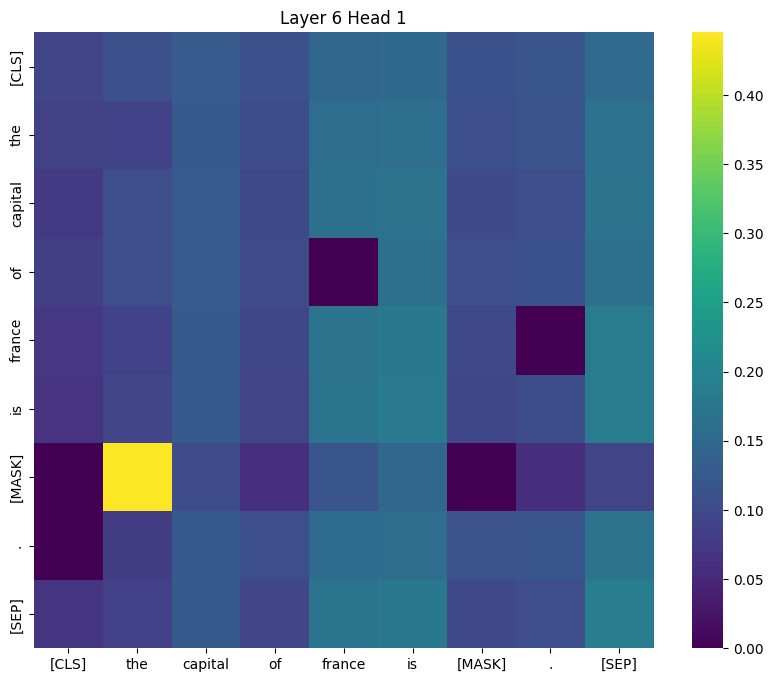

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text = "The capital of France is Paris."
inputs = tokenizer(text, return_tensors="pt")
# Move inputs to GPU if available
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    mlm_logits, nsp_logits, all_attn_weights = model(input_ids, token_type_ids, attention_mask)


# Decode tokens
input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize Layer 0, Head 0
visualize_attention(input_tokens, all_attn_weights, layer=5, head=0)


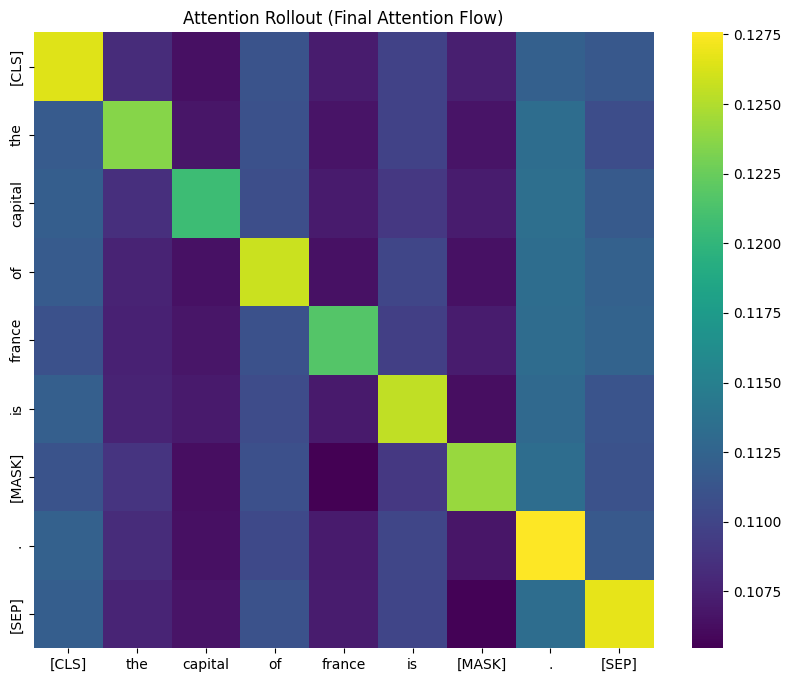

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def attention_rollout(all_attention_weights):
    """
    all_attention_weights: List of [B, Heads, L, L] tensors from each layer.
    """
    rollout = torch.eye(all_attention_weights[0].size(-1)).to(all_attention_weights[0].device)  # Identity matrix [L x L]
    for layer_attn in all_attention_weights:
        # Average across heads: shape [B, L, L]
        attn_avg = layer_attn.mean(dim=1)
        # Add identity connection (residual skip connections in BERT)
        attn_avg = attn_avg + torch.eye(attn_avg.size(-1)).to(attn_avg.device)
        # Normalize rows to sum to 1 (like softmax, but it's residual scaled)
        attn_avg = attn_avg / attn_avg.sum(dim=-1, keepdim=True)
        # Multiply cumulative attention flow
        rollout = attn_avg @ rollout

    return rollout[0].detach().cpu().numpy()  # Return for batch index 0

# Visualize Rollout Attention Map
def visualize_rollout_attention(tokens, rollout_attn):
    plt.figure(figsize=(10, 8))
    sns.heatmap(rollout_attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title("Attention Rollout (Final Attention Flow)")
    plt.show()

# Example Usage
text = "The capital of France is [MASK]."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]
token_type_ids = inputs["token_type_ids"]
attention_mask = inputs["attention_mask"]

with torch.no_grad():
    mlm_logits, nsp_logits, all_attn_weights = model(input_ids, token_type_ids, attention_mask)

# Compute Rollout
rollout_attn = attention_rollout(all_attn_weights)

# Decode tokens
input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize
visualize_rollout_attention(input_tokens, rollout_attn)
